通过openvino转移yolov7模型，通过迁移学习训练yolov7模型学习识别新实体

从yolov7官网https://github.com/WongKinYiu/yolov7下载yolov7模型

从https://github.com/WongKinYiu/yolov7/releases/tag/v0.1选择yolov7-tiny.pt下载

In [2]:
#查看虚拟环境
import os,sys
print(os.path.dirname(sys.executable))

C:\Users\30713\anaconda3\envs\openvino_env


In [7]:
ls

 Volume in drive C is Windows
 Volume Serial Number is 7EA1-53D9

 Directory of C:\Cood\deeplearning_pj\yolov7_pj

2023/12/13  10:05    <DIR>          .
2023/12/13  09:56    <DIR>          ..
2023/12/13  09:59    <DIR>          .ipynb_checkpoints
2023/12/13  10:05             4,616 yolov7.ipynb
2023/12/13  10:02    <DIR>          yolov7-main
               1 File(s)          4,616 bytes
               4 Dir(s)  362,207,477,760 bytes free


当前路径确认为C:\Cood\deeplearning_pj\yolov7_pj,为之前的模型文件设置路径

接下来使用detect.py运行模型对图片进行推理来查看当前模型对于哪些类别无法识别，同时输出图片示例

例子:python detect.py --weights yolov7.pt --conf 0.25 --img-size 640 --source inference/images/horses.jpg

In [13]:
cd yolov7-main

C:\Cood\deeplearning_pj\yolov7_pj\yolov7-main


In [23]:
!python detect.py --weights model/yolov7-tiny.pt --conf 0.25 --img-size 640 --source ../images/bees.jpg

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='../images/bees.jpg', update=False, view_img=False, weights=['model/yolov7-tiny.pt'])
Fusing layers... 
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

Done. (262.8ms) Inference, (0.0ms) NMS
 The image with the result is saved in: runs\detect\exp\bees.jpg
Done. (0.283s)


YOLOR  2023-11-3 torch 1.13.1+cpu CPU

Model Summary: 200 layers, 6219709 parameters, 229245 gradients
C:\Users\30713\anaconda3\envs\openvino_env\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


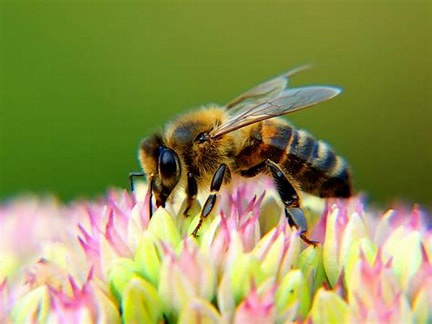

In [24]:
#查看检测后的图片发现模型无法识别蜜蜂
from PIL import Image
# visualize prediction result
Image.open('runs/detect/exp/bees.jpg')

In [25]:
!python detect.py --weights model/yolov7-tiny.pt --conf 0.25 --img-size 640 --source ../images/dog.jpg

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='../images/dog.jpg', update=False, view_img=False, weights=['model/yolov7-tiny.pt'])
Fusing layers... 
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

1 dog, Done. (191.0ms) Inference, (2.0ms) NMS
 The image with the result is saved in: runs\detect\exp2\dog.jpg
Done. (0.200s)


YOLOR  2023-11-3 torch 1.13.1+cpu CPU

Model Summary: 200 layers, 6219709 parameters, 229245 gradients
C:\Users\30713\anaconda3\envs\openvino_env\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


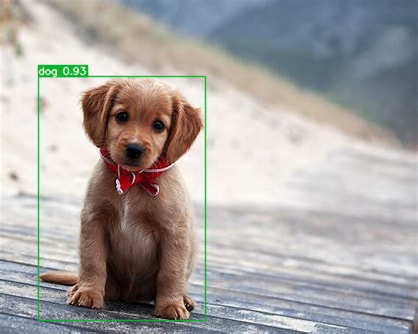

In [27]:
#查看检测后的图片发现模型可以识别dog
from PIL import Image
# visualize prediction result
Image.open('runs/detect/exp2/dog.jpg')

通过实验发现yolov7无法识别蜜蜂，接下来先对于模型类型进行转换，再进行迁移学习训练

先将pt转换为onnx格式再转换成OpenVINO Intermediate Representation (IR)格式

In [30]:
!python -W ignore export.py --weights model/yolov7-tiny.pt --grid

Import onnx_graphsurgeon failure: No module named 'onnx_graphsurgeon'
Namespace(batch_size=1, conf_thres=0.25, device='cpu', dynamic=False, dynamic_batch=False, end2end=False, fp16=False, grid=True, img_size=[640, 640], include_nms=False, int8=False, iou_thres=0.45, max_wh=None, simplify=False, topk_all=100, weights='model/yolov7-tiny.pt')
Fusing layers... 

Starting TorchScript export with torch 1.13.1+cpu...
TorchScript export success, saved as model/yolov7-tiny.torchscript.pt
CoreML export failure: No module named 'coremltools'

Starting TorchScript-Lite export with torch 1.13.1+cpu...
TorchScript-Lite export success, saved as model/yolov7-tiny.torchscript.ptl

Starting ONNX export with onnx 1.15.0...
ONNX export success, saved as model/yolov7-tiny.onnx

Export complete (4.43s). Visualize with https://github.com/lutzroeder/netron.


YOLOR  2023-11-3 torch 1.13.1+cpu CPU

Model Summary: 200 layers, 6219709 parameters, 6219709 gradients


In [32]:
import openvino as ov
model = ov.convert_model('model/yolov7-tiny.onnx')
# 将模型序列化以保存为IR
ov.save_model(model, 'model/yolov7-tiny.xml')